### 1. Helper function 

In [95]:
import cv2
import os
from ultralytics import YOLO
import numpy as np
from typing import List
import time
import argparse
from PIL import Image
import json
import datetime
import matplotlib.pyplot as plt
from IPython.display import display
import IPython
import torch
from pathlib import Path
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import cosine_similarity

In [52]:
class TestDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.PNG') or f.endswith('.png')]

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.filenames[idx])
        image = cv2.imread(img_name)
        if image is None:
            raise FileNotFoundError(f"No image found at {img_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image

In [96]:
def extract_average_features_for_test(dataloader, model, device):

    model.eval()
    averaged_features = []

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            
            # Extract features from the model
            
            features = model(images)
            
            # You might still want to normalize features here, depending on your model architecture
            features = torch.nn.functional.normalize(features, p=2, dim=1)
            
            # Append the features for each batch
            averaged_features.append(features.mean(dim=0))

    # Combine all batch averages to get the overall average
    averaged_features_tensor = torch.stack(averaged_features).mean(dim=0)
    squeezed_features = averaged_features_tensor.unsqueeze(0)

    return squeezed_features


In [88]:
def visualize_cats(image_path):
    fname = os.listdir(image_path)
    print(fname)
    for i in range(len(fname)):
        img_dir = os.path.join(image_path, fname[i])
        image = cv2.imread(img_dir)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()

### 2. config 

In [89]:
data_dir = '/data/etc/molo/CAT_test'
subdir_list = os.listdir(data_dir)

In [90]:
print(subdir_list)

['P_kki', '.DS_Store', 'Q_danpoong', 'R_memil', 'B_miel', 'M_pepper', 'K_vori', 'F_imza', 'N_fall', 'C_lunar', 'L_chewy', 'G_ginger', 'D_rater', 'I_angum', 'E_kakkung', 'H_song', 'S_kongsoon', 'A_cinnamon', 'O_winter', 'J_obok']


In [93]:
## load anchor and negative 
anchor_path = os.path.join(data_dir, subdir_list[0])
anchor_dataset = TestDataset(anchor_path, transform=True)
anchor_dataloader = DataLoader(anchor_dataset, batch_size = 1)

negative_path = os.path.join(data_dir, subdir_list[-1])
negative_dataset = TestDataset(negative_path, transform=True)
negative_dataloader = DataLoader(negative_dataset, batch_size = 1)

['끼 03.png', '끼 01.png', '끼 04.png', '끼 05.png', '끼 02.png']


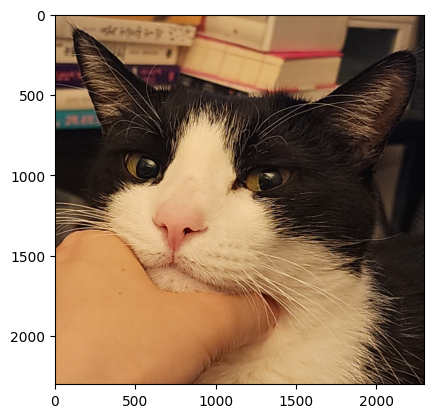

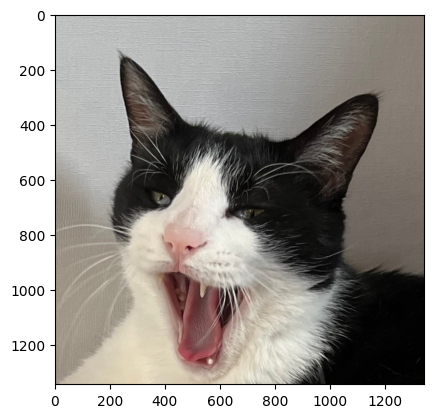

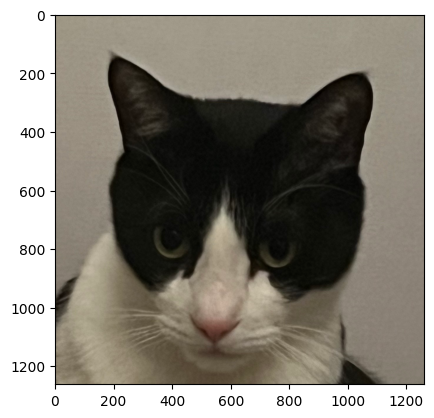

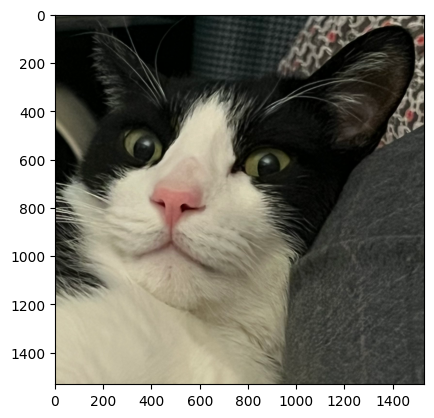

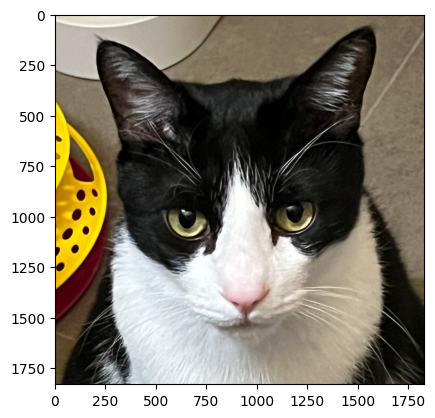

In [92]:
visualize_cats(anchor_path)

In [94]:
model = torch.load('./output/output_model_2024-05-21 23:06:40.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Encoder(
  (backbone): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_featu

### 3. Calculate similarity

In [97]:
anchor = extract_average_features_for_test(anchor_dataloader, model, device)
negative = extract_average_features_for_test(negative_dataloader, model, device)

In [101]:
similarity = cosine_similarity(anchor, negative)

In [102]:
print(f'Similarity between anchor and negative is {similarity}')

Similarity between anchor and negative is tensor([0.9993], device='cuda:0')


In [103]:
n_anchor_features = torch.nn.functional.normalize(anchor, p=2, dim=1)
n_negative_features = torch.nn.functional.normalize(negative, p=2, dim=1)

In [104]:
similarity2 = cosine_similarity(n_anchor_features, n_negative_features)
print(f'Similarity between anchor and negative is {similarity2}')

Similarity between anchor and negative is tensor([0.9993], device='cuda:0')
